# Download flickr dataset

In [ ]:
!wget https://github.com/xu-shitong/flickr8k-CLIP-freature/raw/master/image_all_final.pickle.zip
!wget https://github.com/xu-shitong/flickr8k-CLIP-freature/raw/master/text_all_final.pickle.zip
!wget https://github.com/xu-shitong/flickr8k-CLIP-freature/raw/master/captions.txt.zip
!unzip -q image_all_final.pickle.zip 
!unzip -q text_all_final.pickle.zip
!unzip -q captions.txt.zip
!pip install transformers
!pip install gputil
!pip install psutil
!pip install humanize
!pip install torchtext
!touch summary.txt

# Imports

In [2]:
from PIL import Image
import pandas as pd
import copy
from torchvision.datasets import CocoCaptions
from transformers import (
  DistilBertTokenizer, DistilBertForMaskedLM, DistilBertConfig,
  CLIPProcessor, CLIPModel as CLIP, CLIPConfig,
  activations, PreTrainedTokenizer
)
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import tqdm
import matplotlib.pyplot as plt
import math

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)


/Users/xushitong/miniconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device:  cpu


In [3]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 25.8 GB
GPU 0 ... Mem Free: 15106MB / 15109MB | Utilization   0%


In [ ]:
# download pretrained model and tokenizer
def save_model_tokenizer(tokenizer_class, model_class, name):
  if tokenizer_class is not None:
    tokenizer = tokenizer_class.from_pretrained(name)
    tokenizer.save_pretrained(f"./tokenizers/{name}-local")
  if model_class is not None:
    model = model_class.from_pretrained(name)
    model.save_pretrained(f"./models/{name}-local/")

# save_model_tokenizer(CLIPProcessor, CLIP, "openai/clip-vit-base-patch32")
save_model_tokenizer(DistilBertTokenizer, DistilBertForMaskedLM, "distilbert-base-uncased")


# Hyperparameters

In [118]:
# hyperparameters
DEBUG = True
BATCH_SIZE = 8
MAX_LENGTH = 16 # max text length
LEARNING_RATE = 5e-5
# END_LEARNING_RATE = 5e-5 # learning rate is linearly reduced to end_learning_rate
END_LEARNING_RATE = LEARNING_RATE # no changing learning rate

def cosine_annealing():
  sub_epoch = 5
  x = torch.arange(0, sub_epoch)
  x = END_LEARNING_RATE + (LEARNING_RATE - END_LEARNING_RATE) * (1 + torch.cos(x / sub_epoch * math.pi)) / 2
  return x.repeat((3, ))
# SCHEDULER = torch.logspace
SCHEDULER = torch.linspace
# SCHEDULER = cosine_annealing # scheduler of learning rate
TRAIN_SET_RATIO = 0.95
EARLY_STOP_RATIO = 1.02
EPOCH_NUM = 15
DYNAMIC_ROUNDING_WEIGHT = -1 # weight of rounding term with respect to x_t loss, <0 means not using 
ROUNDING_WEIGHT = 0.3 # weight of rounding term, the probability of regenerated sequence, not used if using dynamic rounding

def series_sum_sample_mean(x_hat, x):
  return (x_hat - x).abs().sum(dim=1).mean()

def series_sum(x_hat, x):
  return (x_hat - x).abs().sum() / BATCH_SIZE / 768 / 100

def mse_series_mean(x_hat, x):
  return ((x_hat - x) ** 2).sum(dim=[-2, -1]).sqrt().mean()

def mse_series_sum(x_hat, x):
  return ((x_hat - x) ** 2).sum(dim=[-2, -1]).sqrt().sum() / BATCH_SIZE

LOSS_FUNC = series_sum_sample_mean
# LOSS_FUNC = series_sum
# LOSS_FUNC = mse_series_mean
# LOSS_FUNC = mse_series_sum # loss function used between embedding 
# CLIP_ADDING_METHOD = "add" # CLIP feature are added as position embedding to sequence of word embedding
CLIP_ADDING_METHOD = "concat" # CLIP feature are appended to sequence of word embedding
# # CLIP_MASK = None
# CLIP_MASK = torch.tensor([1, 0], device=device) # mask indicating if [image, text] clip feature is used, None means use classification free guidance
CLASSIFIER_FREE_WEIGHT = 0
# CLASSIFIER_FREE_WEIGHT = 1 # classifier guidance, <= 0 means no guidance
CLASSIFIER_FREE_PROB = 0.2
TRAIN_EMBEDDING = False # if model use pretrained distilbert embedding, or learn a 16 embedding for each word and project to 768 before pass to bert
if TRAIN_EMBEDDING:
  IN_CHANNEL = 16
else:
  IN_CHANNEL = 768

# diffusion hyperparameter
BETA_MIN = 0.0001
BETA_MAX = 0.02
STEP_TOT = 1000 # total noise adding steps
COSIN_SCHEDULE = True # if alpha sequence is scheduled in cosin instead of linear patten
SAMPLE_SIZE = 100 # number of sample steps in each diffuse sequence
X_0_PREDICTION = True # if model predicts x_0 or x_{t-1}
X_T_STEP_INTERVAL = 100
USE_X_T_LOSS = True
USE_X_1_LOSS = True # if using x_1 loss
USE_PROB_LOSS = True # if using prob loss

MODEL_NAME = f"epoch{EPOCH_NUM}_loss{LOSS_FUNC.__name__}_lr{'%.0E' % LEARNING_RATE}-{'%.0E' % END_LEARNING_RATE}_scheduler{SCHEDULER.__name__}_round{'%.0E' % ROUNDING_WEIGHT}_dynamic{DYNAMIC_ROUNDING_WEIGHT}\
_clip{CLIP_ADDING_METHOD}_class_weight{'%.0E' % CLASSIFIER_FREE_WEIGHT}_class_prob{'%.0E' % CLASSIFIER_FREE_PROB}_train-embed{TRAIN_EMBEDDING}\
_samplesize{SAMPLE_SIZE}_x_0_predict{X_0_PREDICTION}_X_INTERVAL{X_T_STEP_INTERVAL}_use_x_t{USE_X_T_LOSS}_use_x_1{USE_X_1_LOSS}_use_prob{USE_PROB_LOSS}"
print(f"trial name: {MODEL_NAME}")

trial name: epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue


# Define Dataset

In [3]:
flickr8k_image = torch.load("./flickr8k/image_all_final.pickle").to(device).detach()
flickr8k_text = torch.load("./flickr8k/text_all_final.pickle").to(device).detach()
flickr30k_image = torch.load("./flickr30k/flickr30k_clip_image.pickle").to(device).detach()
flickr30k_text = torch.load("./flickr30k/flickr30k_clip_text.pickle").to(device).detach()
image_set = torch.vstack([flickr8k_image, flickr30k_image])
text_set = torch.vstack([flickr8k_text, flickr30k_text])
# image_set = flickr8k_image
# text_set = flickr8k_text

from spacy.lang.en import English
from collections import Counter
import itertools

captions = pd.read_csv("./flickr8k/captions.txt")["caption"]
nlp = English()

sentence_lst = []

for sentences in captions:
  word_lst = [x.text.lower() for x in nlp.tokenizer(sentences)]
  spl = [[]]
  for x, y in itertools.groupby(word_lst, lambda z: z == '.'):
      spl[-1].extend(y)
      if x: spl.append([])
  sentence_lst.extend(spl[:-1])

counter = Counter()
for input_ids in sentence_lst:
    counter.update(input_ids)
vocab_dict = {'START': 0, 'END': 1, 'UNK':2, 'PAD':3}
for k, v in counter.items():
    if v > 10:
      vocab_dict[k] = len(vocab_dict)

class DictTokenizer():
  def __init__(self, dictionary) -> None:
    self.dictionary = dictionary

  def __getitem__(self, i):
    return self.dictionary[i]

  def decode(self, index):
    return " ".join([list(self.dictionary.keys())[list(self.dictionary.values()).index(i.item())] for i in index])



In [136]:

class FlickrCLIPDataset(torch.utils.data.Dataset):
  def __init__(self, captions, images, tokenizer) -> None:
    images.name = "image"
    captions.name = "caption"
    self.data = pd.concat([images, captions], axis=1)
    self.tokenizer = tokenizer

    self.train_dataset = torch.utils.data.TensorDataset(image_set.to(device), text_set.to(device))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_clip, text_clip = self.train_dataset[idx]
    if isinstance(self.tokenizer, PreTrainedTokenizer):
      tokens = self.tokenizer(text=self.data.loc[idx]["caption"], return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LENGTH)
    else:
      ids = [0] + [vocab_dict.get(x, vocab_dict['UNK']) for x in self.data.loc[idx]["caption"][:MAX_LENGTH-2]] + [1] 
      pad_length = max(0, MAX_LENGTH - len(ids))
      tokens = dict()
      tokens["input_ids"] = torch.tensor(ids + [vocab_dict['UNK']] * pad_length)
      tokens["attention_mask"] = torch.tensor([1] * len(ids) + [0] * pad_length)

    return {
      "image_clip": image_clip, 
      "text_clip": text_clip, 
      "input_ids": tokens["input_ids"].squeeze().to(device), 
      "attention_mask": tokens["attention_mask"].squeeze().to(device),
      "text": self.data.loc[idx]["caption"],
      "image": self.data.loc[idx]["image"]
    }

# TODO: COCO dataset

if TRAIN_EMBEDDING:
  tokenizer = DictTokenizer(vocab_dict)
  VOCAB_SIZE = len(vocab_dict)
else:
  tokenizer = DistilBertTokenizer.from_pretrained("./tokenizers/distilbert-base-uncased-local/", local_files_only=True)
  VOCAB_SIZE = tokenizer.vocab_size

dataset = FlickrCLIPDataset(
  # pd.concat([pd.read_csv("./flickr8k/captions.txt")["caption"], pd.read_csv("./flickr30k/captions.csv", sep='|')["caption"]], ignore_index=True),
  # pd.concat([pd.read_csv("./flickr8k/captions.txt")["image"], pd.read_csv("./flickr30k/captions.csv", sep='|')["image_name"]], ignore_index=True),
  pd.read_csv("./flickr8k/captions.txt")["caption"],
  pd.read_csv("./flickr8k/captions.txt")["image"],
  tokenizer)
train_len = int(len(dataset) * TRAIN_SET_RATIO)
train_set, val_set = torch.utils.data.random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
val_loader = DataLoader(val_set, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)


In [29]:
mem_report()

CPU RAM Free: 24.3 GB
GPU 0 ... Mem Free: 1543MB / 15109MB | Utilization  90%


# Model, trainer and loss function

In [119]:
class DistilBertModel(nn.Module):
  def __init__(self, embedding=None, projection=None, config=None) -> None:
    '''
    inputs:
      embedding: clip embedding module
      config
    '''
    super().__init__()

    self.model = DistilBertForMaskedLM(config).to(device)

    if TRAIN_EMBEDDING:
      self.embedding = nn.Embedding(VOCAB_SIZE, IN_CHANNEL, device=device).requires_grad_(True)
      self.lm_head = nn.Linear(IN_CHANNEL, VOCAB_SIZE, bias=False, device=device).requires_grad_(True)

      self.input_projection = nn.Linear(IN_CHANNEL, 768, device=device).requires_grad_(True)
      self.output_projection = nn.Linear(768, IN_CHANNEL, device=device).requires_grad_(True)
    else:
      self.embedding = copy.deepcopy(embedding.requires_grad_(False))
      self.lm_head = copy.deepcopy(projection.requires_grad_(False))
      self.lm_head.bias.data = torch.zeros(self.lm_head.bias.data.shape, device=device).requires_grad_(False)
    
    self.model.set_input_embeddings(nn.Sequential())
    self.model.set_output_embeddings(nn.Sequential())

    self.image_linear = nn.Linear(512, 768, device=device)
    self.text_linear = nn.Linear(512, 768, device=device)

    if CLIP_ADDING_METHOD == "concat":
      self.segment_embedding = nn.Embedding(2, 768, device=device)

  def parameters(self):
    base_list = list(self.model.parameters()) + list(self.image_linear.parameters()) + list(self.text_linear.parameters())
    if TRAIN_EMBEDDING:
      base_list += list(self.embedding.parameters()) + list(self.lm_head.parameters()) \
                  + list(self.input_projection.parameters()) + list(self.output_projection.parameters())

    if CLIP_ADDING_METHOD == "concat":
      return base_list + list(self.segment_embedding.parameters())
    elif CLIP_ADDING_METHOD == "add":
      return base_list
    else:
      raise NotImplementedError(CLIP_ADDING_METHOD)

  def forward(self, x, image_clip, text_clip, mask, concat_mask):
    '''
    input:
      x: [x_t ... x_t], shape: [sample_size * batch_size, seq_len, IN_CHANNEL]
      image_clip, text_clip shape: [sample_size * batch_size, 1, clip_dim]
      mask shape: [sample_size * batch_size, seq_len] 
    
    return 
      vocab_out, shape: [sample_size * batch_size, seq_len, vocab_size]
      feature_out, shape: [sample_size * batch_size, seq_len, IN_CHANNEL]
    '''
    sample_batch_multi, _, _ = x.shape

    assert x.shape == (sample_batch_multi, MAX_LENGTH, IN_CHANNEL)
    assert image_clip.shape == text_clip.shape == (sample_batch_multi, 1, 512)
    assert mask.shape == (sample_batch_multi, MAX_LENGTH)
    assert concat_mask.shape == (sample_batch_multi, 2)

    # mask of which sample is classifier free guided, true if guided
    guidance_sample_index = (concat_mask[:, 1] == 1)

    if TRAIN_EMBEDDING:
      x = self.input_projection(x)
    
    if CLIP_ADDING_METHOD == "concat":
      classifier_guided_mask = torch.hstack([mask, torch.tensor([1, 1], device=device).repeat(sample_batch_multi, 1)])
      non_classifier_mask = torch.hstack([mask, torch.tensor([1, 0], device=device).repeat(sample_batch_multi, 1)])

      x = torch.hstack([x, self.image_linear(image_clip), self.text_linear(text_clip)])
      x = x + self.segment_embedding(torch.tensor([0] * MAX_LENGTH + [1] * 2, device=device))

      classifier_guided_x = non_classifier_x = x
    elif CLIP_ADDING_METHOD == "add":
      classifier_guided_mask = non_classifier_mask = mask

      non_classifier_x = x + self.image_linear(image_clip)
      classifier_guided_x = non_classifier_x + self.text_linear(text_clip)
    else:
      raise NotImplementedError(CLIP_ADDING_METHOD)

    # no classifier guidance part
    x_out = self.model(non_classifier_x, non_classifier_mask)[0]
    if CLASSIFIER_FREE_WEIGHT > 0 and not guidance_sample_index.sum() == 0:
      # classifier guided
      x_out[guidance_sample_index] = \
        (1 + CLASSIFIER_FREE_WEIGHT) * self.model(classifier_guided_x[guidance_sample_index], classifier_guided_mask[guidance_sample_index])[0] \
        - CLASSIFIER_FREE_WEIGHT * x_out[guidance_sample_index]
    
    if TRAIN_EMBEDDING:
      x_out = self.output_projection(x_out)

    assert x_out.shape == (sample_batch_multi, non_classifier_mask.shape[-1], IN_CHANNEL)
    return self.lm_head(x_out[:, :MAX_LENGTH, :]), x_out
    
if TRAIN_EMBEDDING:
  configuration = DistilBertConfig()
  model = DistilBertModel(config=configuration)
else:
  origin = DistilBertForMaskedLM.from_pretrained("./models/distilbert-base-uncased-local", local_files_only=True).to(device)
  configuration = DistilBertConfig()
  model = DistilBertModel(origin.get_input_embeddings(), origin.get_output_embeddings(), config=configuration)

# parameter only include model, no embedding layer
# trainer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)


In [ ]:
clip_origin = CLIP.from_pretrained("./models/openai/clip-vit-base-patch32-local/")
clip_origin

In [120]:
if COSIN_SCHEDULE:
  def scheduler(t):
    s = 0.008 # smalle value prevent beta_t too small, from Improved DDPM paper
    return torch.cos(math.pi / 2 * (t/STEP_TOT + s) / (1 + s)) ** 2
  ts = torch.arange(STEP_TOT).to(device)
  alpha_cumprod = scheduler(ts) / scheduler(torch.zeros(1, device=device))
else:
  betas = torch.hstack([torch.zeros(1), torch.linspace(BETA_MIN, BETA_MAX, STEP_TOT)]).to(device)
  alphas = 1 - betas
  alpha_cumprod = torch.cumprod(alphas[:-1], 0)
def diffuse_t(x, t):
  '''
  input:
    x_shape: [batch_size, seq_len, IN_CHANNEL]
    t shape: [sample num] 
      NOTE: not necessary have hyperparameter sample_size number of element, to allow single diffuse generation

  return shape [sample_num * batch_size, seq_len, IN_CHANNEL]
  '''
  batch_size, seq_len, _ = x.shape
  sample_shape = (t.numel(), *(1, ) * len(x.shape))

  noise = torch.normal(0, 1, x.shape).to(device)
  mean = torch.sqrt(alpha_cumprod[t].reshape(sample_shape)) * x 
  epsilon = noise * torch.sqrt(1 - alpha_cumprod[t]).reshape(sample_shape)
  return (mean + epsilon).reshape((t.numel() * batch_size, seq_len, IN_CHANNEL))

def generate_diffuse_pair(x_0, t, t_next=None):
  '''
  input:
    x_0 shape: [batch_size, seq_len, IN_CHANNEL],
    t shape: [sample_num] 
      NOTE: not necessary have hyperparameter sample_size number of element, to allow single diffuse generation
  
  return (net input, net target)
    net input shape: [sample_num * batch_size, seq_len, IN_CHANNEL]
    net target shape: if t_next is None then [batch_size, seq_len, IN_CHANNEL] else [sample_num * batch_size, seq_len, IN_CHANNEL]
  '''
  if X_0_PREDICTION:
    # predict x_0
    return (diffuse_t(x_0, t), x_0)

  # predict x_{t_next}
  return (diffuse_t(x_0, t), diffuse_t(x_0, t_next))

def loss(model, x_t, x_1, x_tgt, x_0, image_clip, text_clip, mask, idx, loss_func):
  ''' 
  input: 
    model, 
    x_t, x_tgt shape: [sample_num * batch_size, seq_len, IN_CHANNEL]
      NOTE: x_tgt only used when X_0_PREDICTION is False
    x_1, x_0 shape: [batch_size, seq_len, IN_CHANNEL]
    image_clip, text_clip shape: [batch_size, clip_dim]
    mask shape: [batch_size, seq_len]
    idx shape: [batch_size, seq_len]
    loss_func

  return triple loss terms
  '''
  assert x_t.shape == (SAMPLE_SIZE * BATCH_SIZE, MAX_LENGTH, IN_CHANNEL)
  assert x_1.shape == x_0.shape == (BATCH_SIZE, MAX_LENGTH, IN_CHANNEL)
  assert image_clip.shape == text_clip.shape == (BATCH_SIZE, 512)
  assert mask.shape == (BATCH_SIZE, MAX_LENGTH)
  assert idx.shape == (BATCH_SIZE, MAX_LENGTH)
  
  repeat_shape = (SAMPLE_SIZE, *(1, ) * (len(x_t.shape) - 1))
  image_clip = image_clip.unsqueeze(1) # shape [ batch_size, 1, clip_dim]
  text_clip = text_clip.unsqueeze(1) # shape same as above

  if CLASSIFIER_FREE_WEIGHT > 0:
    classifier_mask = (torch.rand((SAMPLE_SIZE * BATCH_SIZE, 1)) > CLASSIFIER_FREE_PROB).type(torch.float32).to(device)
    classifier_mask[0] = 0
    classifier_mask[1] = 1 # prevent no sample or all sample use classifier
    concat_mask = torch.hstack([torch.ones((SAMPLE_SIZE * BATCH_SIZE, 1), device=device), classifier_mask])
  else:
    concat_mask = torch.tensor([1, 0], device=device).repeat((SAMPLE_SIZE * BATCH_SIZE, 1))

  # x_t restore loss
  x_t_prob, x_t_hidden = model(x_t, image_clip.repeat(repeat_shape), text_clip.repeat(repeat_shape), mask.repeat((SAMPLE_SIZE, 1)), concat_mask)
  if USE_X_T_LOSS:
    if X_0_PREDICTION:
      x_t_loss = loss_func(x_t_hidden[:, :MAX_LENGTH, :], x_0.repeat(repeat_shape))
    else:
      assert x_tgt.shape == x_t.shape
      x_t_loss = loss_func(x_t_hidden[:, :MAX_LENGTH, :], x_tgt)
  else:
    x_t_loss = 0

  # x_1 restore loss
  x_1_prob, x_1_hidden = model(x_1, image_clip, text_clip, mask, torch.tensor([1, 0], device=device).repeat((BATCH_SIZE, 1)))
  if USE_X_1_LOSS:
    x_1_loss = loss_func(x_1_hidden[:, :MAX_LENGTH, :], x_0)
  else:
    x_1_loss = 0

  if USE_PROB_LOSS:
    # output sequence probability loss, applied to both x_1 and x_t restore
    idx = idx.unsqueeze(dim=-1)
    if LOSS_FUNC == series_sum_sample_mean or LOSS_FUNC == mse_series_mean:
      x_t_prob_loss = -(nn.functional.softmax(x_t_prob, dim=-1)).gather(-1, idx.repeat(repeat_shape)).log().sum(dim=1).mean()
      x_1_prob_loss = -(nn.functional.softmax(x_1_prob, dim=-1)).gather(-1, idx).log().sum(dim=1).mean()
    else:
      x_t_prob_loss = -(nn.functional.softmax(x_t_prob, dim=-1)).gather(-1, idx.repeat(repeat_shape)).log().sum() / BATCH_SIZE
      x_1_prob_loss = -(nn.functional.softmax(x_1_prob, dim=-1)).gather(-1, idx).log().sum() / BATCH_SIZE
  else:
    x_t_prob_loss = 0
    x_1_prob_loss = 0
  
  return x_t_loss, x_1_loss, ROUNDING_WEIGHT * (x_t_prob_loss + x_1_prob_loss)


In [ ]:
mem_report()

# Training

In [183]:
if SCHEDULER == torch.linspace:
  lrs = SCHEDULER(LEARNING_RATE, END_LEARNING_RATE, EPOCH_NUM)
elif SCHEDULER == torch.logspace:
  lrs = SCHEDULER(torch.tensor([LEARNING_RATE]).log10().item(), torch.tensor([END_LEARNING_RATE]).log10().item(), EPOCH_NUM)
elif SCHEDULER == cosine_annealing:
  lrs = SCHEDULER()

def train_func(model, trainer, x, train=True):
  x_0 = model.embedding(x["input_ids"])
  repeat_shape = (SAMPLE_SIZE, *(1, ) * (len(x_0.shape) - 1))
  t = torch.randint(0, STEP_TOT, repeat_shape, device=device)
  
  if X_0_PREDICTION:
    x_t = diffuse_t(x_0, t)
    x_tgt = None
  else:
    x_t, x_tgt = generate_diffuse_pair(x_0, t, torch.max(t - X_T_STEP_INTERVAL, torch.zeros(t.shape, device=device, dtype=torch.int64)))
  x_1 = diffuse_t(x_0, torch.ones(1, dtype=torch.int64, device=device))

  if train:
    trainer.zero_grad()
  x_t_loss, x_1_loss, prob_loss = loss(
    model, 
    x_t, x_1, x_tgt, x_0, 
    x["image_clip"], x["text_clip"], 
    x["attention_mask"], 
    x["input_ids"], 
    LOSS_FUNC
  )
  
  l = x_t_loss + x_1_loss + prob_loss
  if train:
    l.backward()
    trainer.step()

  return l, x_t_loss, x_1_loss, prob_loss

def validate(model):
  val_acc_x_t = 0
  val_acc_x_1 = 0
  val_acc_prob = 0
  model.eval()
  with torch.no_grad():
    for batch_num, x in enumerate(val_loader):
      _, x_t_loss, x_1_loss, prob_loss = train_func(model, trainer, x, train=False)
      val_acc_x_t += x_t_loss
      val_acc_x_1 += x_1_loss
      val_acc_prob += prob_loss
  model.train()

  return val_acc_x_t / len(val_loader), val_acc_x_1 / len(val_loader), val_acc_prob / len(val_loader), 

In [186]:
# training 
# model = torch.load(f"{MODEL_NAME}.pickle").to(device)
# model.model.add_module("activation", activations.GELUActivation())
# trainer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# summary = open(f"{MODEL_NAME}.txt", "a")
summary = sys.stdout

early_stopped = False
model.train()
print("start training")
for epoch in range(EPOCH_NUM):
  acc_x_t = 0
  acc_x_1 = 0
  acc_prob = 0
  acc_l = 0
  if not END_LEARNING_RATE == LEARNING_RATE:
    for g in trainer.param_groups:
      g['lr'] = lrs[epoch]

  # with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
  #   for batch_num, x in enumerate(tepoch):
  for batch_num, x in enumerate(train_loader):

      l, x_t_loss, x_1_loss, prob_loss = train_func(model, trainer, x)
      
      acc_x_t += x_t_loss
      acc_x_1 += x_1_loss
      acc_prob += prob_loss
      acc_l += l

      if DYNAMIC_ROUNDING_WEIGHT > 0:
        ROUNDING_WEIGHT = ((acc_x_t + acc_x_1) / acc_prob).detach() * DYNAMIC_ROUNDING_WEIGHT

      # tepoch.set_description(f"batch {batch_num}")
      # tepoch.set_postfix(
      #                    x_t_hidden=x_t_loss.item(),
      #                    x_1_loss=x_1_loss.item(),
      #                    prob_loss=prob_loss.item(),
      #                    tot_loss=l.item())
      if DEBUG:
        break

  val_x_t, val_x_1, val_prob = validate(model)
  if val_x_t + val_x_1 + val_prob > EARLY_STOP_RATIO * acc_l / len(train_loader):
    if not early_stopped:
      summary.write("early stop! \n")
      torch.save(model.cpu(), f"{MODEL_NAME}.pickle")
      model = model.to(device)
    early_stopped = True
  summary.write(f"epoch {epoch} average x_t_loss, x_1_loss, prob_loss, val losses: {acc_x_t / len(train_loader)}, {acc_x_1 / len(train_loader)}, {acc_prob / len(train_loader)}, {val_x_t}, {val_x_1}, {val_prob}\n")
    
  if DEBUG:
    break


start training
torch.Size([800, 16, 1])


In [ ]:
if not early_stopped:
  torch.save(model.cpu(), f"{MODEL_NAME}.pickle")
  model = model.to(device)

In [ ]:
mem_report()


# Evaluate

In [8]:
summary = sys.stdout

In [124]:
# trial on inference
model = torch.load(
  # "epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue-new.pickle",
  "epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.pickle",

  ).to(device)
model.model.add_module("activation", activations.GELUActivation())
model.eval()
with torch.no_grad():

  idx = 0
  summary.write(f"origin text: {val_set[idx]['text']}\n")

  sample = val_set[idx]
  image_clip = sample["image_clip"][None, None, :]
  text_clip = sample["text_clip"][None, None, :]

  x_0 = model.embedding(sample["input_ids"].unsqueeze(0))
  t = 999
  summary.write(f"t = {t}\n")
  x_t = diffuse_t(x_0, torch.tensor([t], dtype=torch.int64, device=device))
  mask = sample["attention_mask"].unsqueeze(0)

  # multi-step inference
  restored = x_t
  for i in range(10):
    out, restored = model(restored[:, :MAX_LENGTH, :], image_clip, text_clip, mask, torch.tensor([1, 0], device=device).repeat(mask.shape[0], 1))
    summary.write(f"inferred: {dataset.tokenizer.decode(out.argmax(dim=-1)[0])}\n")

  # effectiveness of model on large t
  summary.write("text t effectiveness\n")
  for i in range(1, STEP_TOT, 100):
    x_t = diffuse_t(x_0, torch.tensor([i], dtype=torch.int64, device=device))
    out, _ = model(x_t, image_clip, text_clip, mask, torch.tensor([1, 0], device=device).repeat(mask.shape[0], 1)) 

    summary.write(f"t: {i} restore: {dataset.tokenizer.decode(out.argmax(dim=-1)[0])}\n")

if not summary == sys.stdout:
  summary.close()


origin text: A girl , in a green field , plays soccer .
t = 999
inferred: [CLS] a girl in a green a field is playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field field is playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field field is playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field field is playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field field playing playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field is playing playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field is playing playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field is playing playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field is playing playing soccer. [SEP] [PAD] [PAD] [PAD]
inferred: [CLS] a girl in a green field is playing playing soccer. [SEP] [PAD] [PAD] [PAD]
text t effectiveness
t: 1 restore: 

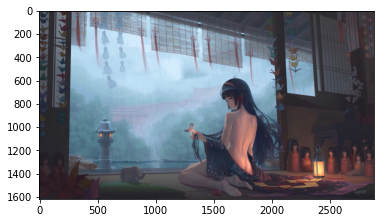

inferred:  [CLS] a woman woman sitting in a a a a a a a a. [SEP]
inferred:  [CLS] an asian woman sitting on a a chair in a a in fire. [SEP]
inferred:  [CLS] an asian woman sitting on a a chair outside a a lit fire. [SEP]
inferred:  [CLS] an asian woman sitting on a chair in front of a large tree. [SEP]
inferred:  [CLS] an asian woman sitting on a chair in front of a large tree. [SEP]

inferred:  [CLS] a woman woman sitting a a a a a a a a a. [SEP]
inferred:  [CLS] a asian woman sitting sitting in a chair near a table in fire. [SEP]
inferred:  [CLS] an asian woman is sitting on the chair near a table of fire. [SEP]
inferred:  [CLS] an asian woman is sitting on the chair near a table in front. [SEP]
inferred:  [CLS] an asian woman is sitting on the chair at a table in front of [SEP]

inferred:  [CLS] a woman woman sitting in a a a a a a a a. [SEP]
inferred:  [CLS] an asian woman sitting in a a chair in front of a fire. [SEP]
inferred:  [CLS] an asian woman sitting on a a chair in front o

In [80]:
# Zero shot trial
# model = torch.load(
#   "./batch8_maxlen16_round3E-01_lossseries_sum_batch_average_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_use_x_1True_use_probTrue.pickle"
#   ).to(device)
# model.model.add_module("activation", activations.GELUActivation())
model.eval()
with torch.no_grad():
  image = Image.open("./lianhua.jpg")
  clip_processor = CLIPProcessor.from_pretrained("./tokenizers/openai/clip-vit-base-patch32-local")
  clip = CLIP.from_pretrained("./models/openai/clip-vit-base-patch32-local")
  plt.imshow(image)
  plt.show()
  inputs = clip_processor(text="", images=image, return_tensors="pt", padding=True)
  # inputs_no = clip_processor(text=text, images=None, return_tensors="pt", padding=True)

  image_clip = clip.get_image_features(pixel_values=inputs["pixel_values"]).unsqueeze(0)
  image_clip = image_clip / image_clip.norm(p=2, dim=-1, keepdim=True)

  # image_clip = torch.zeros((1, 1, 512))

  # text_clip = linear_model(image_clip)
  text_clip = torch.zeros_like(image_clip)

  # multi-step inference
  for _ in range(10):
    restored = torch.randn((1, 18, 768), device=device)
    for i in range(10):
      
      out, restored = model(restored[:, :MAX_LENGTH, :], image_clip, text_clip, torch.ones((1, MAX_LENGTH)), torch.tensor([[1, 0]]))

      if i % 2 == 0:
        print("inferred: ", dataset.tokenizer.decode(nn.functional.softmax(out, dim=-1).argmax(dim=-1)[0]))
    print()


# Metrics Evaluations

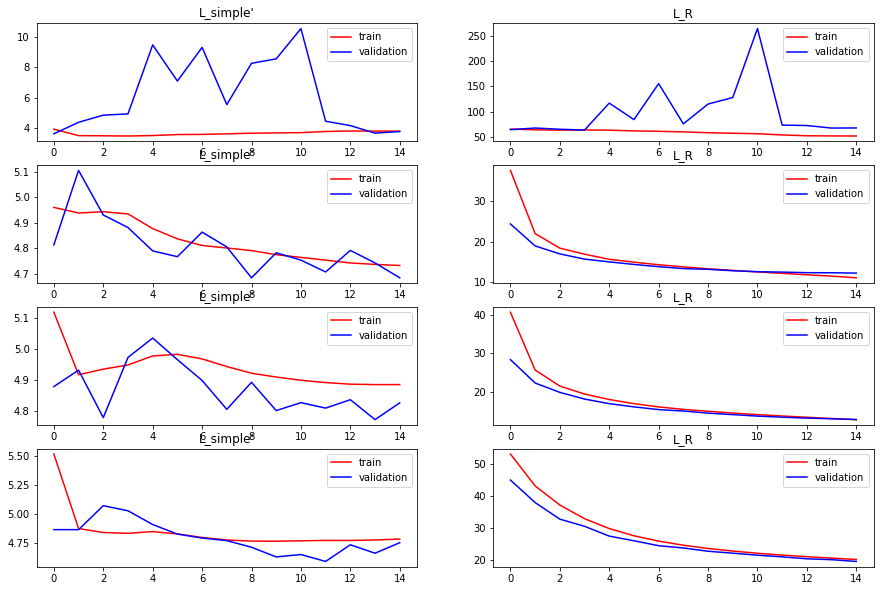

In [46]:
# plot train and validation error

def extract_float(file_name, start=""):
  def isfloat(word):
    try:
      float(word)
      return True
    except ValueError:
      return False
  import re
  file = open(file_name)
  l = [[float(word) for word in re.split("\n|,| ", line) if isfloat(word)] for line in file if line.startswith(start)]
  return torch.tensor(l)

small_baseline = "./trial_add_concat/epoch15_lossseries_sum_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_1True_use_probTrue.txt"


# file_names = [ # 5.1 add or concat
#   "./trial_add_concat/epoch15_lossseries_sum_sample_mean_lr1E-04-1E-04_schedulerlinspace_round3E-01_dynamic-1_clipadd_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   small_baseline,
#   "./trial_add_concat/epoch30_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipadd_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   "epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
# ]
# fig, axarr = plt.subplots(1, 5, figsize=(20, 3))
# names = ["addition Flickr8k", "concat Flickr8k", "addition 30+8k", "concat 30+8k"]
# axarr[4].set_title("val L_diffuseLM")
# for i, file_name in enumerate(file_names):
#   losses = extract_float(file_name, start="epoch")[:20] # shape [batch size, 7] each line is [batch number, x_t, x_1, prob losses, validation x_t x_1 prob losses]
#   axarr[i].set_title(names[i])
#   axarr[i].plot(losses[:, 1], color='r', label="train L'_simple")
#   axarr[i].plot(losses[:, 4], color='b', label="val L'_simple")
#   axarr[4].plot(losses[:, 4] + losses[:, 6], label=names[i])
#   axarr[i].legend(loc="upper right")
#   axarr[4].legend(loc="upper right")

# file_names = [ # 5.2 part 1, rounding weight
#   "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round1E+00_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round5E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   small_baseline,
#   "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round2E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
# ]
# fig, axarr = plt.subplots(1, 5, figsize=(20, 3))
# names = ["lambda = 1.0", "lambda = 0.5", "lambda = 0.3", "lambda = 0.2"]
# lambdas = [1.0, 0.5, 0.3, 0.2]
# axarr[4].set_title("rounding loss")
# for i, file_name in enumerate(file_names):
#   losses = extract_float(file_name, start="epoch") # shape [batch size, 7] each line is [batch number, x_t, x_1, prob losses, validation x_t x_1 prob losses]
#   axarr[i].set_title(names[i])
#   axarr[i].plot(losses[:, 1], color='r', label="train L'_simple")
#   axarr[i].plot(losses[:, 4], color='b', label="val L'_simple")
#   # axarr[4].plot(losses[:, 3], label=names[i])
#   axarr[i].legend(loc="upper right")
#   axarr[4].plot(losses[:, 3] / lambdas[i], label=names[i])
# axarr[4].legend(loc="upper right")

# file_names = [ # 5.2 part 2, dynamic rounding weight
#   small_baseline,
#   "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr1E-04-1E-04_schedulerlinspace_round3E-01_dynamic1_clipconcat_class_weight-1E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E+00_dynamic3_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
# ]
# fig, axarr = plt.subplots(1, 4, figsize=(20, 3))
# names = ["lambda = 0.3 const", "C = 1", "C = 3"]
# axarr[3].set_title("rounding loss")
# for i, file_name in enumerate(file_names):
#   losses = extract_float(file_name, start="epoch") # shape [batch size, 7] each line is [batch number, x_t, x_1, prob losses, validation x_t x_1 prob losses]
#   axarr[i].set_title(names[i])
#   axarr[i].plot(losses[:, 1], color='r', label="train L'_simple")
#   axarr[i].plot(losses[:, 4], color='b', label="val L'_simple")
#   # axarr[4].plot(losses[:, 3], label=names[i])
#   axarr[i].legend(loc="upper right")
#   axarr[3].plot(losses[:, 3], label=names[i])
# axarr[3].legend(loc="upper right")

# # classifier free trial, 5.3
# file_names = [
#   small_baseline,
#   "./trial_classification_free/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight1E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   "./trial_classification_free/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight3E-01_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
# ]

file_names = [ # 5.4 part 1, const learning rate !!
  "./trial_lr/epoch15_lossseries_sum_sample_mean_lr5E-04-5E-04_schedulerlinspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
  "./trial_lr/epoch15_lossseries_sum_sample_mean_lr1E-04-1E-04_schedulerlogspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
  small_baseline,
  "./trial_lr/epoch15_lossseries_sum_sample_mean_lr1E-05-1E-05_schedulerlogspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
]
fig, axarr = plt.subplots(len(file_names), 2, figsize=(15, 10))
for i, file_name in enumerate(file_names):
  losses = extract_float(file_name, start="epoch") # shape [batch size, 7] each line is [batch number, x_t, x_1, prob losses, validation x_t x_1 prob losses]
  train_index = {1: "L_simple'", 3: "L_R"}
  val_index = {4: "L_simple'", 6: "L_R"}
  train_sum_losses = losses[:, list(train_index.keys())].sum(dim=-1)
  val_sum_losses = losses[:, list(val_index.keys())].sum(dim=-1)

  for j, idx in enumerate(train_index):
    axarr[i, j].plot(losses[:, idx], color='r', label="train")
    axarr[i, j].set_title(train_index[idx])
    axarr[i, j].legend(loc="upper right")

  for j, idx in enumerate(val_index):
    axarr[i, j].plot(losses[:, idx], color='b', label="validation")
    axarr[i, j].set_title(val_index[idx])
    axarr[i, j].legend(loc="upper right")


# file_names = [ # 5.4 part 2 !!
#   small_baseline,  
#   "./trial_lr/epoch15_lossseries_sum_sample_mean_lr1E-04-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   "./trial_lr/epoch15_lossseries_sum_sample_mean_lr1E-04-5E-05_schedulercosine_annealing_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   "./trial_lr/epoch15_lossseries_sum_sample_mean_lr1E-04-5E-05_schedulerlogspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
# ]
# # fig, axarr = plt.subplots(len(file_names), 4, figsize=(15, 10))
# fig, axarr = plt.subplots(len(file_names), 3, figsize=(15, 10))
# for i, file_name in enumerate(file_names):
#   losses = extract_float(file_name, start="epoch") # shape [batch size, 7] each line is [batch number, x_t, x_1, prob losses, validation x_t x_1 prob losses]
#   # train_index = {1: "x_t_loss",2: "x_1_loss",3: "prob_loss"}
#   # val_index = {4: "x_t_loss",5: "x_1_loss",6: "prob_loss"}
#   train_index = {1: "x_t_loss", 3: "prob_loss"}
#   val_index = {4: "x_t_loss", 6: "prob_loss"}
#   train_sum_losses = losses[:, list(train_index.keys())].sum(dim=-1)
#   val_sum_losses = losses[:, list(val_index.keys())].sum(dim=-1)

#   for j, idx in enumerate(train_index):
#     axarr[i, j].plot(losses[:, idx])
#     axarr[i, j].set_title(train_index[idx])

#   for j, idx in enumerate(val_index):
#     axarr[i, j].plot(losses[:, idx])
#     axarr[i, j].set_title(val_index[idx])

#   # axarr[i, 3].plot(train_sum_losses)
#   # axarr[i, 3].plot(val_sum_losses)
#   axarr[i, 2].plot(train_sum_losses)
#   axarr[i, 2].plot(val_sum_losses)

# file_names = [ # 5.5 x_0 or x_t trial
#   "./trial_x_01_prediction/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_class_weight0E+00_class_prob2E-01_train-embedFalse_samplesize100_x_0_predictFalse_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
#   small_baseline,
# ]

# # # file_names = [
# # #   "./trial_add_concat/epoch15_lossseries_sum_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_1True_use_probTrue.txt",
# # #   "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.txt",
# # # ]

# # fig, axarr = plt.subplots(len(file_names), 4, figsize=(15, 10))
# fig, axarr = plt.subplots(len(file_names), 3, figsize=(15, 10))
# for i, file_name in enumerate(file_names):
#   losses = extract_float(file_name, start="epoch") # shape [batch size, 7] each line is [batch number, x_t, x_1, prob losses, validation x_t x_1 prob losses]
#   # train_index = {1: "x_t_loss",2: "x_1_loss",3: "prob_loss"}
#   # val_index = {4: "x_t_loss",5: "x_1_loss",6: "prob_loss"}
#   train_index = {1: "x_t_loss", 3: "prob_loss"}
#   val_index = {4: "x_t_loss", 6: "prob_loss"}
#   train_sum_losses = losses[:, list(train_index.keys())].sum(dim=-1)
#   val_sum_losses = losses[:, list(val_index.keys())].sum(dim=-1)

#   for j, idx in enumerate(train_index):
#     axarr[i, j].plot(losses[:, idx])
#     axarr[i, j].set_title(train_index[idx])

#   for j, idx in enumerate(val_index):
#     axarr[i, j].plot(losses[:, idx])
#     axarr[i, j].set_title(val_index[idx])

#   # axarr[i, 3].plot(train_sum_losses)
#   # axarr[i, 3].plot(val_sum_losses)
#   axarr[i, 2].plot(train_sum_losses)
#   axarr[i, 2].plot(val_sum_losses)



In [ ]:
from torchvision import datasets

class COCOCLIPDataset(torch.utils.data.Dataset):
  def __init__(self, path2data, path2json) -> None:
    super().__init__()
    coco_val = datasets.CocoDetection(root = path2data,
                                    annFile = path2json)
    coco_loader = DataLoader(coco_val, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

  def __getitem__(self, idx):
    


COCOCLIPDataset(path2data="./coco_2014_caption/val2014/", path2json="./coco_2014_caption/val2014_caption.json")



In [139]:
from torchmetrics import BLEUScore

model = torch.load(
  # "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round1E+00_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.pickle"
  # "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round5E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.pickle"
  # "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.pickle"
  # "./trial_rounding_weight/epoch15_lossseries_sum_sample_mean_lr5E-05-5E-05_schedulerlogspace_round2E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_tTrue_use_x_1True_use_probTrue.pickle"
  "./trial_add_concat/epoch15_lossseries_sum_lr5E-05-5E-05_schedulerlinspace_round3E-01_dynamic-1_clipconcat_clipmask10_train-embedFalse_samplesize100_x_0_predictTrue_X_INTERVAL100_use_x_1True_use_probTrue.pickle"
  ).to(device)
model.model.add_module("activation", activations.GELUActivation())
model.eval()
metric = BLEUScore()
acc_bleu = 0
with torch.no_grad():
  with tqdm.tqdm(val_loader, unit="batch") as tepoch: 
    for j, x in enumerate(tepoch):
  # for x in val_loader:

      restored = torch.randn((x["input_ids"].shape[0], MAX_LENGTH + 2, IN_CHANNEL), device=device)

      # each prediction involves multiple generation steps
      for i in range(5):
        out, restored = model(restored[:, :MAX_LENGTH, :], x["image_clip"].unsqueeze(1), torch.zeros_like(x["image_clip"], device=device).unsqueeze(1), torch.ones((x["input_ids"].shape[0], MAX_LENGTH), device=device), torch.tensor([1, 0], device=device).repeat(x["attention_mask"].shape[0], 1))
      
      # append final strings to each answer bin
      indexes = nn.functional.softmax(out, dim=-1).argmax(dim=-1)
      indexes = indexes.unique_consecutive(dim=-1)

      ans_strs = [dataset.tokenizer.decode(index) for index in indexes]

      GT_list = []
      GT_list_capped = []
      for image_name in x["image"]:
        GT_list.append(['[CLS] ' + caption.strip().lower() + ' [SEP]' for caption in dataset.data.loc[dataset.data['image'] == image_name]["caption"]])

      acc_bleu += metric(ans_strs, GT_list)
      if j >= 100:
        break
print(acc_bleu / 100)


 40%|███▉      | 100/252 [02:03<03:07,  1.23s/batch]

tensor(0.1735)


In [122]:
acc_bleu

tensor(0.)

In [624]:
ans_strs, GT_list

(['[CLS] the hiker with a black and orange backpack walks away into the wooded area. [SEP]',
  '[CLS] a child is eating something very close to the camera while other children sit at a table behind him. [SEP]',
  '[CLS] a girl with ice skate sits on a fence checking her cellphone while her friend looks on. [SEP]',
  '[CLS] grayhound dog standing in still water. [SEP]',
  '[CLS] the boy with glasses is sitting and reading a book. [SEP]',
  '[CLS] two boys do martial arts on a blue mat. [SEP]',
  '[CLS] two large dogs run along a muddy path. [SEP]',
  '[CLS] two males on a street corner crooswalk with a billboard behind them. [SEP]'],
 [['[CLS] a hiker wearing an orange backpack is walking through long grass . [SEP]',
   '[CLS] a man walking in brush with a big orange backpack . [SEP]',
   '[CLS] a man with an orange backpack in an bushy area . [SEP]',
   '[CLS] a person with a large backpack hiking through the tall grass . [SEP]',
   '[CLS] the hiker with a black and orange backpack wal

In [600]:
# evaluate BLEU-4 metrics on validation data
from torchtext.data.metrics import bleu_score
import re
# model = torch.load(
#   "./stashed_output/batch8_maxlen16_round3E-01_lossseries_sum_batch_average_clipconcat_clipmask10_train-embedFalse_samplesize100.pickle"
# ).to(device)
# model.model.add_module("activation", activations.GELUActivation())
DEBUG = True
model.eval()
print("evaluate on validation set")
acc_bleu = 0
with torch.no_grad():
  with tqdm.tqdm(val_loader, unit="batch") as tepoch: 
    for j, x in enumerate(tepoch):
  # for x in val_loader:

      restored = torch.randn((x["input_ids"].shape[0], MAX_LENGTH + 2, IN_CHANNEL), device=device)

      # each prediction involves multiple generation steps
      for i in range(5):
        out, restored = model(restored[:, :MAX_LENGTH, :], x["image_clip"].unsqueeze(1), torch.zeros_like(x["image_clip"], device=device).unsqueeze(1), torch.ones((x["input_ids"].shape[0], MAX_LENGTH), device=device), torch.tensor([1, 0], device=device).repeat(x["attention_mask"].shape[0], 1))
      
      # append final strings to each answer bin
      indexes = nn.functional.softmax(out, dim=-1).argmax(dim=-1)
      indexes = indexes.unique_consecutive(dim=-1)
      # indexes = dataset.tokenizer(x["text"])["input_ids"]

      ans_strs = [re.split("\.| ", dataset.tokenizer.decode(index))[:MAX_LENGTH] for index in indexes]

      GT_list = []
      for image_name in x["image"]:
        GT_list.append([['[CLS]'] + re.split("\.| ", caption.strip().lower())[:MAX_LENGTH-2] + ['[SEP]'] for caption in dataset.data.loc[dataset.data['image'] == image_name]["caption"]])

      acc_bleu += bleu_score(ans_strs, GT_list)

      # if DEBUG and j > 10:
      if DEBUG:
        print(ans_strs)
        print()
        print(GT_list)
        break

print("bleu score: ", acc_bleu / len(val_loader))
print("bleu score: ", acc_bleu )


evaluate on validation set


  0%|          | 0/252 [00:04<?, ?batch/s]

[['[CLS]', 'the', 'backpackr', 'with', 'a', 'black', 'orange', 'orange', 'backpack', 'is', 'walking', 'down', 'the', 'trail', '[SEP]'], ['[CLS]', 'a', 'black', 'dog', 'is', 'a', 'and', 'white', 'dog', 'with', 'a', 'white', 'dog', 'in', 'a', '[SEP]'], ['[CLS]', 'a', 'girl', 'wearing', 'ice', 'helmet', 'is', 'sitting', 'on', 'a', 'a', 'a', 'cellphone', 'cell', '[SEP]'], ['[CLS]', 'closeup', 'of', 'dog', 'in', 'the', 'water', 'with', 'a', 'standing', 'in', 'the', 'water', '', '[SEP]'], ['[CLS]', 'the', 'boy', 'with', 'glasses', 'is', 'sitting', 'and', 'reading', 'and', 'and', 'reading', 'the', 'book', '', '[SEP]'], ['[CLS]', 'a', 'person', 'with', 'a', 'pink', 'shirt', 'with', 'a', 'pink', 'hair', 'is', 'standing', 'on', 'the', '[SEP]'], ['[CLS]', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'in', 'water', '', '[SEP]'], ['[CLS]', 'a', 'brown', 'dog', 'is', 'playing', 'with', 'a', 'white', 'dog', 'with', 'and', 'white', 'dog', '', '[SEP]']]

[[['[CLS]', 'a'

In [ ]:
dataset.data["image"].drop_duplicates()

In [597]:
from torchvision import datasets

path2data="./coco_2014_caption/val2014/"
path2json="./coco_2014_caption/val2014_caption.json"

coco_val = datasets.CocoDetection(root = path2data,
                                annFile = path2json)
coco_loader = DataLoader(coco_val, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [599]:
coco_val[0], Image.open("./Shropshire.jpg")

((<PIL.Image.Image image mode=RGB size=640x478>,
  [{'image_id': 42,
    'id': 641613,
    'caption': 'This wire metal rack holds several pairs of shoes and sandals'},
   {'image_id': 42,
    'id': 645309,
    'caption': 'A dog sleeping on a show rack in the shoes.'},
   {'image_id': 42,
    'id': 650217,
    'caption': 'Various slides and other footwear rest in a metal basket outdoors.'},
   {'image_id': 42,
    'id': 650868,
    'caption': 'A small dog is curled up on top of the shoes'},
   {'image_id': 42,
    'id': 652383,
    'caption': 'a shoe rack with some shoes and a dog sleeping on them'}]),
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x1438>)

In [88]:
from google.colab import drive
drive.mount('/gdrive')

ModuleNotFoundError: No module named 'google'

In [ ]:
!cp -av {MODEL_NAME} f'/gdrive/MyDrive/{MODEL_NAME}.pickle'